## Inspect fields
This notebook makes it easy to check whether the two fields from ERA5 + GCM are behaving consistently.

In [1]:
import xarray as xr 
import numpy as np 
import os 
FIGDIR = '../../figures'
DATADIR = '../../data'
exp = 'AD99 c0=u0 (include unbroken)'
expcode = 'always_include_unbroken_1year'
ERA5_DATASET = f"/scratch/users/robcking/era5_{expcode}.nc"
GCM_DATASET = f"/scratch/users/robcking/mima_gwf_{expcode}.nc"


ds_era5 = xr.open_dataset(ERA5_DATASET)
ds_gcm = xr.open_dataset(GCM_DATASET)



In [2]:
LEVEL = 2#hpa
ds_era5_start = ds_era5.isel(time=0).sel(level=LEVEL)
ds_gcm_start = ds_gcm.isel(time=0).sel(level=LEVEL)

Text(0.5, 1.0, 'GCM')

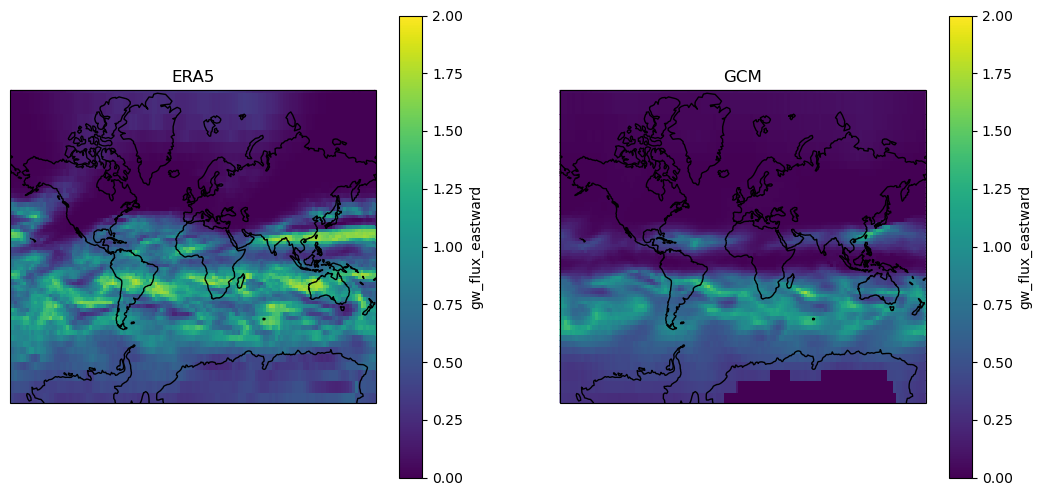

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
fig,(ax1,ax2) = plt.subplots(1,2,subplot_kw={'projection':ccrs.Mercator()},figsize=(13,6))
ax1.coastlines()

ax2.coastlines()



(ds_era5_start.gw_flux_eastward*1000).plot.pcolormesh(ax=ax1,x='longitude',y='latitude',transform=ccrs.PlateCarree(),vmin=0,vmax=2)
(ds_gcm_start.gw_flux_eastward*1000).plot.pcolormesh(ax=ax2,x='longitude',y='latitude',transform=ccrs.PlateCarree(),vmin=0,vmax=2)
ax1.set_title("ERA5")
ax2.set_title("GCM")

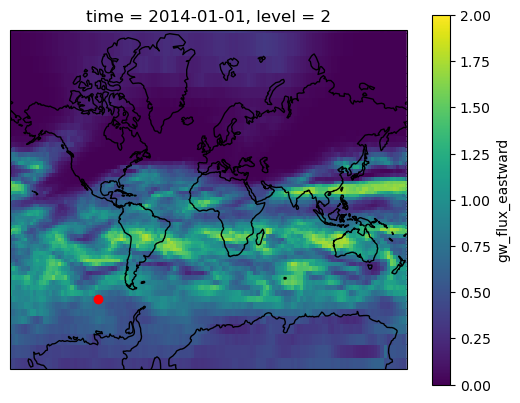

In [5]:
LAT = -60.0
LON = 260.0

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
(ds_era5_start.gw_flux_eastward*1000).plot.pcolormesh(ax=ax,x='longitude',y='latitude',transform=ccrs.PlateCarree(),vmin=0,vmax=2)
ax.scatter([LON],[LAT],transform=ccrs.PlateCarree(),c='r')
ax.coastlines()

In [6]:
zonalx_era5 = ds_era5.u.mean(['longitude','time'])
zonalx_gcm = ds_gcm.ucomp.mean(['longitude','time'])

Text(0.5, 1.0, 'GCM')

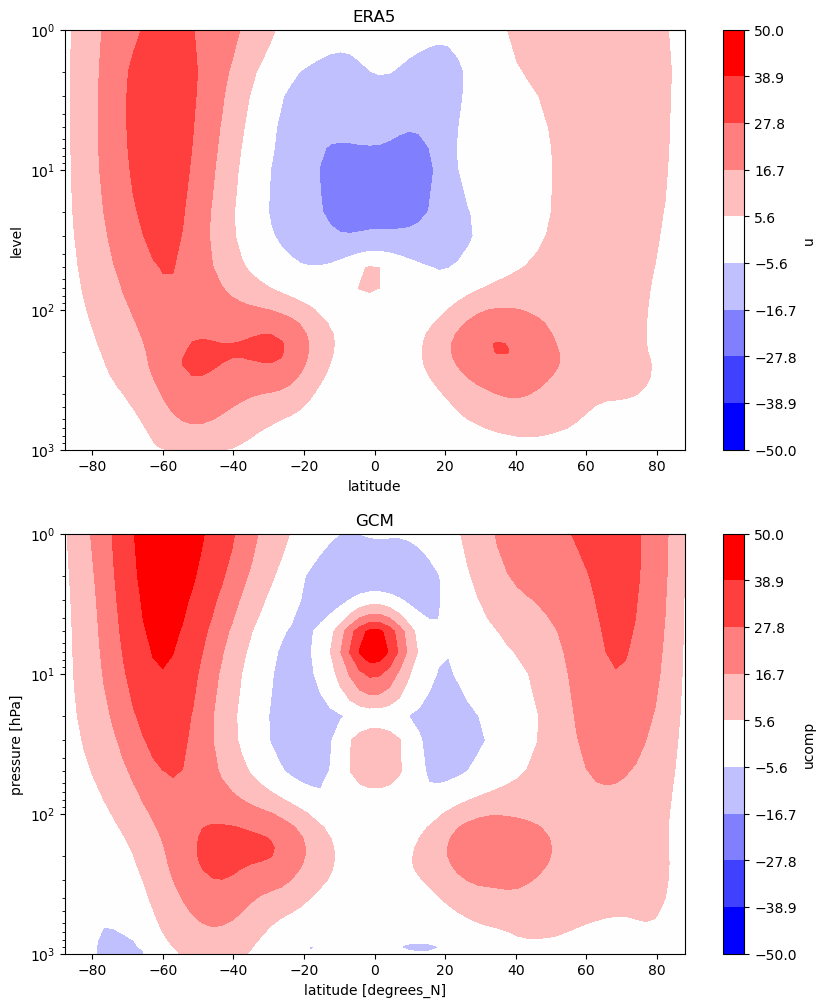

In [7]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,12))
zonalx_era5.plot.contourf(ax=ax1,x='latitude',y='level',yincrease=False,yscale='log',levels=10,vmin=-50,vmax=50,cmap='bwr')
ax1.set_title("ERA5")

zonalx_gcm.plot.contourf(ax=ax2,x='latitude',y='level',yincrease=False,yscale='log',levels=10,vmin=-50,vmax=50,cmap='bwr')
ax2.set_title("GCM")

In [8]:
u_era5 = ds_era5.u.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values
N_era5 = ds_era5.Ns.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values
z_era5 = ds_era5.z.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values
rho_era5 = ds_era5.rho.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values
total_flux_era5 = ds_era5.gw_flux_eastward.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values - ds_era5.gw_flux_westward.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values


u_gcm = ds_gcm.ucomp.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values
N_gcm = ds_gcm.Ns.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values
z_gcm = ds_gcm.height.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values
rho_gcm = ds_gcm.rho.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values
flux_gcm = ds_gcm.gw_flux_eastward.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values
total_flux_gcm = ds_gcm.gw_flux_eastward.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values - ds_gcm.gw_flux_westward.sel(latitude=LAT,longitude=LON,method='nearest').isel(time=0).values


In [9]:
from ad99py import AlexanderDunkerton1999

ad99 = AlexanderDunkerton1999(Fs0=4.3e-3,cw=35,exclude_unbroken=False,use_intrinsic_c='always',dc=1.2)

era5_ntv,era5_ptv = ad99.momentum_flux_neg_ptv(u_era5,N_era5,z_era5,rho_era5,LAT)
gcm_ntv,gcm_ptv = ad99.momentum_flux_neg_ptv(u_gcm,N_gcm,z_gcm,rho_gcm,LAT)

reflecting,breaking = ad99.get_breaking_levels(u_era5,N_era5,z_era5,rho_era5,LAT)
reflecting_gcm,breaking_gcm = ad99.get_breaking_levels(u_gcm,N_gcm,z_gcm,rho_gcm,LAT)

i_source_era5 = ad99.get_source_level(z_era5,LAT)
i_source_gcm =ad99.get_source_level(z_gcm,LAT)

total_era5 = era5_ptv - era5_ntv
total_gcm = gcm_ptv - gcm_ntv

/home/groups/aditis2/robcking/ad99py/src/ad99py/ad99.py:65: UserWarning: `source` is not set, using default Gaussian source spectrum, with `cw=35` and `Bm=0.4`.
  warn(f"`source` is not set, using default Gaussian source spectrum, with `cw={cw}` and `Bm={Bm}`.")


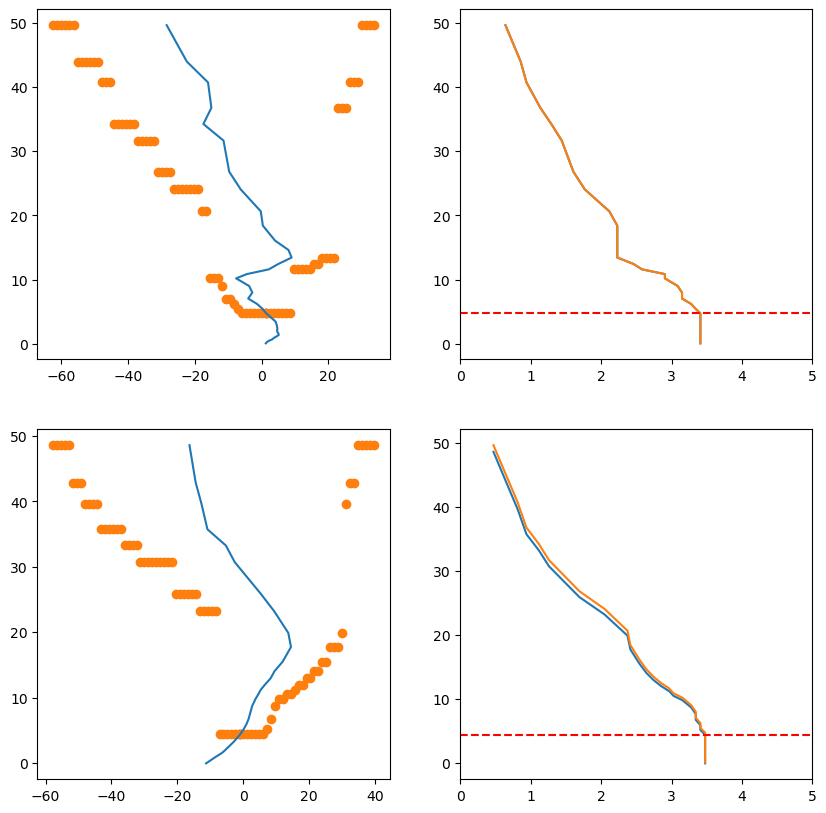

In [10]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.plot(u_era5,z_era5/1000)
ax2.plot(total_era5*1000,z_era5/1000)
ax2.plot(total_flux_era5*1000,z_era5/1000)
ax2.set_xlim(0,5)
ax1.scatter(u_era5[i_source_era5],z_era5[i_source_era5]/1000,color='red')
ax2.axhline(z_era5[i_source_era5]/1000,color='red',ls='--')
ax1.scatter(ad99.c0[reflecting>0], z_era5[reflecting][reflecting>0]/1000)
ax1.scatter(ad99.c0[breaking>0], z_era5[breaking][breaking>0]/1000)

ax3.plot(u_gcm,z_gcm/1000)
ax4.plot(total_gcm*1000,z_gcm/1000)
ax4.plot(total_flux_gcm*1000,z_era5/1000)
ax4.set_xlim(0,5)
ax3.scatter(u_gcm[i_source_gcm],z_gcm[i_source_gcm]/1000,color='red')
ax4.axhline(z_gcm[i_source_gcm]/1000,color='red',ls='--')

ax3.scatter(ad99.c0[reflecting_gcm>0], z_gcm[reflecting_gcm][reflecting_gcm>0]/1000)
ax3.scatter(ad99.c0[breaking_gcm>0], z_gcm[breaking_gcm][breaking_gcm>0]/1000)

Text(0.5, 0, 'Density ($kg/m^3$)')

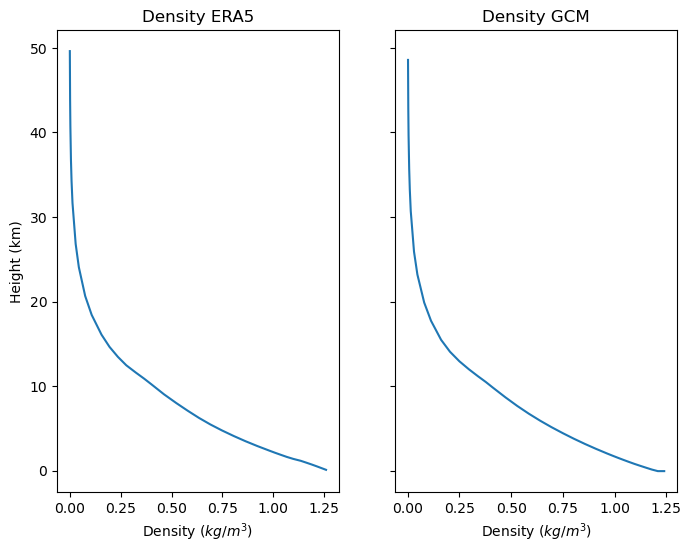

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,6),sharey=True)
ax1.set_title("Density ERA5")
ax1.plot(rho_era5,z_era5/1000)
ax1.set_ylabel("Height (km)")
ax2.set_title("Density GCM")
ax2.plot(rho_gcm,z_gcm/1000)
ax2.set_xlabel("Density ($kg/m^3$)")
ax1.set_xlabel("Density ($kg/m^3$)")